# Stock Classification

## Table of Contents:
1. [Summary of Notebook](#Summary)
2. [Environment Setup](#env_setup)
3. [Load Tickers](#load-tickers)
4. [Missing Values](#missing-values)
5. [EDA on Sectors and Subsectors](#eda)

## Summary of Notebook <a id='Summary'></a>

**Project Background**: Global Industry Classification Standard (GICS) is a common global classification standard used by thousands of market participants across all major groups involved in the investment process. Each stock in the S&P 500 belongs to a GICS sector such as Information Technology, Financials, Industrials, Health Care, etc. Moreover, every GICS also has subsectors.

**Project Goal**: Given the multiple daily time series of a stock (Open, Close, High, Low, Adjusted Price, and Volume), predict the GICS sector of given stock.

**Methods**: Dataset contains multiple daily time series of $358$ stocks obtained from yahoo finance (after filtering from $500$ stocks) from the start of $2016$ till the end of $2018$, and the GICS sector obtained from wikipedia is chosen to be the label to be predicted. The features were mostly generated by tsfresh library and hurst exponent. Exploratory data analysis is carried out on useful features. Processed data is then used in an XGBoost model to predict GICS sector.

In [1]:
%load_ext autoreload
%autoreload 2

## Environment Setup <a id='env_setup'></a>

Libraries

In [2]:
import os
import sys
import datetime as dt

import pandas as pd
import matplotlib.pyplot as plt

List of directories

In [3]:
DIRECTORY_DATA = '../data/external/'

DIRECTORY_TICKERS = '../data/inter/tickers/'

TICKERS_UNFILTERED_FILENAME = 'tickers_unfiltered.pkl'

TICKERS_FILTERED_FILENAME = 'tickers_filtered.pkl'

TICKERS_FILENAME = 'tickers.pkl'

Global variables

In [5]:
START_YEAR = 2016
START_MONTH = 1
START_DAY = 1

END_YEAR = 2019
END_MONTH = 1
END_DAY = 1

START_DATE = dt.datetime(START_YEAR,START_MONTH,START_DAY)
END_DATE = dt.datetime(END_YEAR,END_MONTH,END_DAY)

NUMBER_DAYS = 754

## Load Tickers <a id='load-tickers'></a>

In [6]:
tickers_unfiltered = pd.read_pickle(os.path.join(DIRECTORY_TICKERS,TICKERS_UNFILTERED_FILENAME))

In [7]:
tickers_unfiltered

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...,...
491,YUM,Yum! Brands,reports,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
492,ZBRA,Zebra Technologies,reports,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
493,ZBH,Zimmer Biomet,reports,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
494,ZION,Zions Bancorp,reports,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


## Missing Values <a id='missing-values'></a>

In [8]:
stocks_unfiltered = sorted([filename.split('.')[0] for filename in os.listdir(DIRECTORY_DATA) if filename.endswith('.pkl')])
df_stocks = pd.DataFrame(columns=['Symbol','df'])
for stock_file in stocks_unfiltered:
    df = pd.read_pickle(os.path.join(DIRECTORY_DATA,f'{stock_file}.pkl'))
    df_stocks = df_stocks.append({'Symbol': stock_file,
                                  'df': df},ignore_index=True)

In [9]:
stocks_with_missing_values = []
for i in range(len(df_stocks)):
    if len(df_stocks.iloc[i,:]['df']) < NUMBER_DAYS:
        stocks_with_missing_values.append(df_stocks.iloc[i,:]['Symbol'])
        print(df_stocks.iloc[i,:]['Symbol'],len(df_stocks.iloc[i,:]['df']))

CDAY 172
FTV 628
HWM 544
IR 412
LW 537
MRNA 16
UA 699


In [10]:
tickers_missing_values = pd.DataFrame(data={'Symbol':stocks_with_missing_values})

Remove stocks with missing values

In [11]:
tickers_filtered = pd.merge(tickers_unfiltered,tickers_missing_values,on=['Symbol','Symbol'], how='outer',indicator=True)
tickers_filtered = tickers_filtered[tickers_filtered['_merge'] == 'left_only']
tickers_filtered = tickers_filtered.loc[:, ~tickers_filtered.columns.isin(['_merge'])].reset_index(drop=True)

In [12]:
for stock in stocks_with_missing_values:
    os.remove(os.path.join(DIRECTORY_DATA,f'{stock}.pkl'))

In [13]:
tickers_filtered.to_pickle(os.path.join(DIRECTORY_TICKERS,TICKERS_FILTERED_FILENAME))

## EDA on Sectors and Subsectors <a id='eda'></a>

In [14]:
tickers_filtered['GICS Sector'].unique()

array(['Industrials', 'Health Care', 'Information Technology',
       'Communication Services', 'Consumer Discretionary', 'Utilities',
       'Financials', 'Materials', 'Real Estate', 'Consumer Staples',
       'Energy'], dtype=object)

In [15]:
tickers_sector_count = tickers_filtered['GICS Sector'].value_counts().rename_axis('GICS Sector').reset_index(name='count')

In [16]:
tickers_sector_count

,GICS Sector,count
0,Information Technology,74
1,Industrials,68
2,Financials,64
3,Health Care,62
4,Consumer Discretionary,62
5,Consumer Staples,30
6,Real Estate,29
7,Utilities,28
8,Materials,26
9,Communication Services,25


In [17]:
tickers_subsector_count = tickers_filtered.groupby('GICS Sector')['GICS Sub-Industry'].nunique().reset_index(name='GICS Sub-Industry count')

In [18]:
tickers_subsector_count.sort_values(by='GICS Sub-Industry count',ascending=False).reset_index(drop=True)

,GICS Sector,GICS Sub-Industry count
0,Consumer Discretionary,20
1,Industrials,17
2,Information Technology,13
3,Consumer Staples,12
4,Financials,12
5,Communication Services,10
6,Health Care,10
7,Materials,10
8,Real Estate,8
9,Energy,5


In [19]:
tickers_sector_subsectors = pd.merge(tickers_sector_count,
                                     tickers_subsector_count,
                                     on=['GICS Sector','GICS Sector'],
                                     how='inner')

In [20]:
tickers_sector_subsectors

,GICS Sector,count,GICS Sub-Industry count
0,Information Technology,74,13
1,Industrials,68,17
2,Financials,64,12
3,Health Care,62,10
4,Consumer Discretionary,62,20
5,Consumer Staples,30,12
6,Real Estate,29,8
7,Utilities,28,5
8,Materials,26,10
9,Communication Services,25,10


Create a column that represents the ratio of the number of stocks per sector to the number of subsectors per sector

In [21]:
tickers_sector_subsectors['sector_stocks_subsectors'] = tickers_sector_subsectors['count']/tickers_sector_subsectors['GICS Sub-Industry count']

In [22]:
tickers_sector_subsectors

,GICS Sector,count,GICS Sub-Industry count,sector_stocks_subsectors
0,Information Technology,74,13,5.692308
1,Industrials,68,17,4.000000
2,Financials,64,12,5.333333
3,Health Care,62,10,6.200000
4,Consumer Discretionary,62,20,3.100000
5,Consumer Staples,30,12,2.500000
6,Real Estate,29,8,3.625000
7,Utilities,28,5,5.600000
8,Materials,26,10,2.600000
9,Communication Services,25,10,2.500000


Filter Under-represented GICS Sectors

Energy, Communication Services, Materials, Real Estate, and Consumer Staples are removed because they have a low number of stocks and sector_stocks_subsector ratio to represent them well in the dataset.

In [23]:
tickers = tickers_filtered[(tickers_filtered['GICS Sector'] != 'Energy') &
                           (tickers_filtered['GICS Sector'] != 'Communication Services') &
                           (tickers_filtered['GICS Sector'] != 'Materials') &
                           (tickers_filtered['GICS Sector'] != 'Real Estate') &
                           (tickers_filtered['GICS Sector'] != 'Consumer Staples')]
tickers.to_pickle(os.path.join(DIRECTORY_TICKERS,TICKERS_FILENAME))

In [24]:
tickers_removed = [ticker for ticker in set(tickers_filtered['Symbol'].to_list()) if ticker not in set(tickers['Symbol'].to_list())]
for stock in tickers_removed:
    os.remove(os.path.join(DIRECTORY_DATA,f'{stock}.pkl'))

In [25]:
tickers_sector_count = tickers['GICS Sector'].value_counts().rename_axis('GICS Sector').reset_index(name='count')

In [26]:
tickers_sector_count

,GICS Sector,count
0,Information Technology,74
1,Industrials,68
2,Financials,64
3,Health Care,62
4,Consumer Discretionary,62
5,Utilities,28


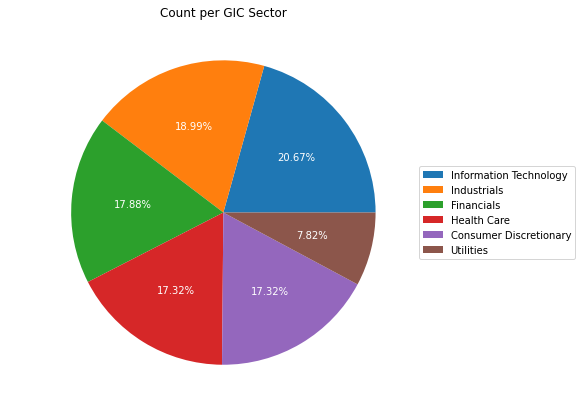

In [27]:
tickers_sector_count.plot.pie(y='count', figsize=(7,7),labels = tickers_sector_count['GICS Sector'],
                        title= "Count per GICS Sector",autopct='%1.2f%%',textprops={'color':"w"})
plt.ylabel('')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [28]:
tickers_subsector_count = tickers.groupby('GICS Sector')['GICS Sub-Industry'].nunique().reset_index(name='GICS Sub-Industry count')

In [29]:
tickers_subsector_count.sort_values(by='GICS Sub-Industry count',ascending=False).reset_index(drop=True)

,GICS Sector,GICS Sub-Industry count
0,Consumer Discretionary,20
1,Industrials,17
2,Information Technology,13
3,Financials,12
4,Health Care,10
5,Utilities,5


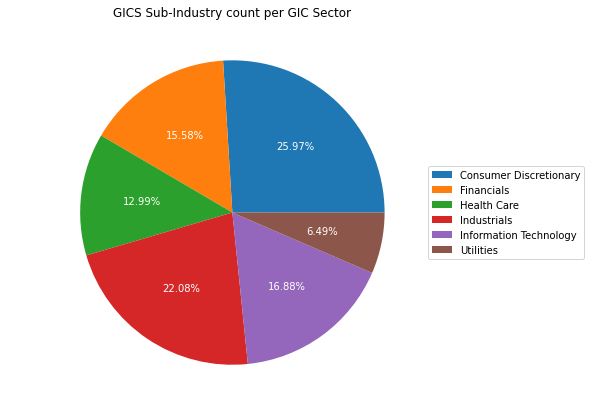

In [30]:
tickers_subsector_count.plot.pie(y='GICS Sub-Industry count', figsize=(7,7),
                                 labels = tickers_subsector_count['GICS Sector'],
                                 title= "GICS Sub-Industry count per GIC Sector",
                                 autopct='%1.2f%%',textprops={'color':"w"})
plt.ylabel('')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));